In [1]:
## Analytical Placement Toy ##

In [2]:
# Step 0-1: Import Libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


In [3]:
# Step 0-2: Define Parameters
GAMMA = 1.0
LR    = 0.5
ITER  = 100

In [4]:
class Netlist:
    def __init__(self):
        self.cells_name = []
        self.cells_size = []
        self.cells_pos  = [] # pos is center of cell
        self.nets       = []

In [5]:
# Step 2: Define Util Functions
# Visualize Initial and Optimized Placements
def plot_placement(ax, board_size, netlist, iteration, total_hpwl):
    ax.clear()
    for net in netlist.nets:
        net_cells = netlist.cells_pos[net]
        ax.plot(net_cells[:, 0], net_cells[:, 1], 'r--', alpha=0.5)  # Draw nets

    for i, (pos, size) in enumerate(zip(netlist.cells_pos, netlist.cells_size)):
        rect = plt.Rectangle(pos - size / 2, size[0], size[1], edgecolor='blue', facecolor='none')
        ax.add_patch(rect)
        ax.text(pos[0], pos[1], netlist.cells_name[i], ha='center', va='center', fontsize=8, color='blue')

    ax.set_xlim(0, board_size)
    ax.set_ylim(0, board_size)
    ax.set_title(f'Placement at Iteration {iteration}, HPWL: {total_hpwl:.2f}')
    ax.grid(True)
# Initialize Placement
def initialize_placement(num_cells, board_size):
    np.random.seed(666)  # For reproducibility
    cells = np.random.rand(num_cells, 2) * board_size  # Random positions within the canvas
    return cells

In [6]:
# Test Case
# Assume we have 5 cells and 4 nets connecting them
board_size = 32
netlist = Netlist()
netlist.cells_name = ['A', 'B', 'C', 'D', 'E', 'F']
netlist.cells_size = np.array([[3,3], [3,3], [1,2], [2,1], [1,1], [1,1]])
netlist.cells_pos = np.zeros((len(netlist.cells_name), 2))
netlist.nets = np.array([[0, 1], [1, 2], [2, 3], [3, 4], [4, 5]])
#nets = [[2,4,5],[0,1,3],[0,2,3,5],[0,1,2,3,4]]

In [7]:
# Initialize random positions for cells (2D positions: x, y)
np.random.seed(666)  # For reproducibility
init_pos = initialize_placement(len(netlist.cells_name), board_size)

### LSE Wirelength Model:  
$
W_{LSE}(\mathbf{x}, \mathbf{y}) = \gamma \sum_{e \in E} \left( \ln \sum_{v_k \in e} \exp(x_k / \gamma) + \ln \sum_{v_k \in e} \exp(-x_k / \gamma)  
                                                                + \ln \sum_{v_k \in e} \exp(y_k / \gamma) + \ln \sum_{v_k \in e} \exp(-y_k / \gamma) \right)
$

In [8]:
# Step 3: Define Objective Function
# Wirelength as the Log-Sum-Exp HPWL 
def log_sum_exp_hpwl(positions, nets, gamma=1.0):
    # wl_x = r * sum( ln(sum( exp(x_k/r) )) + ln(sum( exp(-x_k/r) )) )    ### max(x) + -min(x)   ### -min(x) = max(-x)
    total_hpwl = 0.0
    for net in nets:
        xs = positions[net, 0]
        ys = positions[net, 1]
        wl_x = gamma * ( np.log(np.sum(np.exp(xs / gamma))) + np.log(np.sum(np.exp(-xs / gamma))) )
        wl_y = gamma * ( np.log(np.sum(np.exp(ys / gamma))) + np.log(np.sum(np.exp(-ys / gamma))) )
        total_hpwl += wl_x + wl_y
    return total_hpwl
def hpwl(positions, nets):
    # HPWL_x = max(x) - min(x)
    hpwl = 0
    for cell_ids in nets: # for each net
        x_coords = positions[cell_ids, 0]
        y_coords = positions[cell_ids, 1]
        hpwl += (x_coords.max() - x_coords.min()) + (y_coords.max() - y_coords.min())
    return hpwl

### Gradient Descent
We have $LSE_{x}$
$$
\small
LSE_{x} = \log \sum e^{x_i / \gamma} + \log \sum e^{-x_i / \gamma}
$$
Partial derivative with respect to $x_i$ --> we can get the gradient to optimize WL for $x_i$
$$
\small
\frac{\partial \text{LSE}_{x}}{\partial x_i} = \left( e^{x_i / \gamma} \Big/ \sum e^{x_j / \gamma} \right) - \left( e^{-x_i / \gamma} \Big/ \sum e^{-x_j / \gamma} \right)
$$

In [9]:
# Step 4: Gradient Descent Optimization
# Gradient descent to minimize objective function
def calculate_wl_gradient(netlist, gamma=1.0):
    cells = netlist.cells_pos; nets = netlist.nets
    grads = np.zeros_like(cells) # gradient
    for cell_ids in nets: # for each net
        xs = cells[cell_ids, 0]
        ys = cells[cell_ids, 1]
        exp_xs = np.exp(xs / gamma)       # max(x)
        exp_neg_xs = np.exp(-xs / gamma)  # -min(x)
        exp_ys = np.exp(ys / gamma)       # max(y)
        exp_neg_ys = np.exp(-ys / gamma)  # -min(y)

        grad_xs = gamma * ( (exp_xs / np.sum(exp_xs)) - (exp_neg_xs / np.sum(exp_neg_xs)) ) # partial derivative for each x_i
        grad_ys = gamma * ( (exp_ys / np.sum(exp_ys)) - (exp_neg_ys / np.sum(exp_neg_ys)) )

        grads[cell_ids, 0] += grad_xs
        grads[cell_ids, 1] += grad_ys
    return grads
# Update cell positions using gradient descent
def update_positions(cells_pos, gradient, learning_rate=0.1):
    cells_pos -= learning_rate * gradient
    return cells_pos

### Run

In [ ]:
## Main analytical placement function ## 
# Initialize cells positions and parameters
netlist.cells_pos = init_pos.copy()
num_iter = ITER
gamma = GAMMA
step_size = LR

fig, ax = plt.subplots(figsize=(5, 5))
# Iteratively optimize placement
for iter in range(num_iter):
    # Calculate wirelength
    total_hpwl = hpwl(netlist.cells_pos, netlist.nets)
    total_lse = log_sum_exp_hpwl(netlist.cells_pos, netlist.nets, gamma=gamma)
    # print(f'\rIteration {iter}: LSE Wirelength = {total_hpwl:.2f}', end='')

    # Calculate gradient
    gradient = calculate_wl_gradient(netlist)
    # Update positions
    netlist.cells_pos = update_positions(netlist.cells_pos, gradient, learning_rate=step_size)

    # Plot placement
    plot_placement(ax, board_size, netlist, iter, total_hpwl)
    display(fig)
    clear_output(wait=True)
    plt.pause(0.01)

### Better Optimizer: CG (Conjugate Gradient) with Dynemic Step Size  

In [10]:
# CG (conjugate gradient) with Dynemic Step Size
# Compute β_k (Polak-Ribiere formula) with scaling to avoid overflow
def compute_beta_polak_ribiere_xy(grad, g_prev):
    """
    grad, g_prev: shape (N, 2)
    returns: beta: shape (N, 2)，對 x/y 各自計算 β
    """
    eps = 1e-10
    # Compute maximum absolute value for scaling to avoid overflow
    max_grad = np.maximum(np.max(np.abs(grad), axis=0), np.max(np.abs(g_prev), axis=0))
    max_grad = np.where(max_grad < eps, eps, max_grad)
    # Normalize the gradients
    grad_scaled = grad / max_grad
    g_prev_scaled = g_prev / max_grad
    # Numerator: g_k^T (g_k - g_{k-1})
    diff = grad_scaled - g_prev_scaled
    numerator = grad_scaled * diff
    # Denominator: g_{k-1}^T g_{k-1}
    denominator = g_prev_scaled ** 2 + eps
    denominator = np.where(denominator < eps, eps, denominator)  # avoid divide by 0
    # Beta: Polak-Ribiere formula
    beta = numerator / denominator  # element-wise (N,2)
    return beta
# Update cell positions
def update_positions_cg(cells_pos, g_prev, d_prev, grad, step_size=1.0, is_fixed=None):
    # (0) set movable mask
    if is_fixed is None:
        is_fixed = np.zeros(len(cells_pos), dtype=bool)
    is_fixed = is_fixed.astype(bool)
    movable_mask = ~is_fixed[:, None]  # shape: (N, 1)

    # (1) We have gradient directions grad = g_k = ∇f(x_k)
    # (2) Compute Polak-Ribiere parameter β_k (accelerate (sum) if gradient become better. slow down (subtract) if gradient become slower; go back (subtract very much) if gradient become bad)
    # beta = grad * (grad - g_prev) / np.sum(g_prev**2, axis=0)
    beta = compute_beta_polak_ribiere_xy(grad, g_prev)
    # beta = np.clip(beta, 0, None)  # make sure β_k >= 0
    # (3) Compute conjugate directions d = -grad + beta*d_prev
    dir = -grad + beta * d_prev # d_prev.shape = (N, 2)
    # (4) Compute step size alpha = s/norm(d)
    alpha = step_size / np.linalg.norm(dir, axis=0)
    # (5) update positions: x = x_prev + alpha*d
    cells_pos += (alpha * dir) * movable_mask
    return cells_pos, dir

### Run

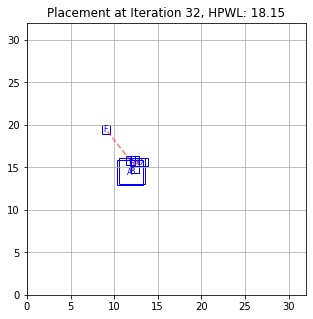

In [33]:
## Main analytical placement function ## 
# Initialize cells positions and parameters
netlist.cells_pos = init_pos.copy()
num_iter = ITER
gamma = GAMMA
step_size = board_size / 20

fig, ax = plt.subplots(figsize=(5, 5), facecolor='white')

g_prev = np.zeros_like(netlist.cells_pos)  # init grad = 0
d_prev = np.zeros_like(netlist.cells_pos)  # init dir = 0
total_lse_prev = 1000000000
lse_history = []
stop_iter = []
early_stop = False
# Iteratively optimize placement
for iter in range(num_iter):
    # Calculate wirelength
    total_hpwl = hpwl(netlist.cells_pos, netlist.nets)
    total_lse = log_sum_exp_hpwl(netlist.cells_pos, netlist.nets, gamma=gamma)
    # print(f'\rIteration {iter}: LSE Wirelength = {total_hpwl:.2f}', end='')

    # Calculate gradient
    gradient = calculate_wl_gradient(netlist)
    # Update positions
    netlist.cells_pos, dk = update_positions_cg(netlist.cells_pos, g_prev, d_prev, gradient, step_size=step_size)
    if total_lse > total_lse_prev:
        stop_iter.append(iter)
    if iter > 50 and np.linalg.norm(gradient) > np.linalg.norm(g_prev):
        # print(f'Converged at iteration {iter}')
        early_stop = True
    g_prev = gradient.copy(); d_prev = dk.copy()
    total_lse_prev = total_lse
    lse_history.append(total_lse)


    # Plot placement
    plot_placement(ax, board_size, netlist, iter, total_lse)
    display(fig)
    clear_output(wait=True)
    plt.pause(0.01)

    if early_stop:
        break

In [32]:
print(stop_iter)
for i, lse in enumerate(lse_history):
    print(i, lse)


[17, 21, 22, 23, 27, 28, 31, 32]
0 91.47644198643356
1 83.33509645342187
2 76.06260046860199
3 69.31928659038786
4 63.10207500046253
5 57.60028471401474
6 53.10353586663016
7 49.087303759356665
8 45.396774600033844
9 41.76841551698903
10 38.196802657475864
11 34.88328292827658
12 32.016123775429115
13 29.460351332426214
14 27.465126123993542
15 26.540590264723875
16 26.290170792672328
17 26.427832891195827
18 25.36796395882314
19 21.70648482805704
20 20.316501903770337
21 21.241609624252135
22 23.630887188840084
23 25.48426860368469
24 24.886729008899138
25 21.349306794545832
26 20.22541649246321
27 23.115745302197524
28 23.407489825445328
29 18.92595483570384
30 15.678892307197813
31 15.878455525727082
32 18.147268477030657
